In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

In [3]:
# shape of the image : 50x50
# number of classes : 62
# number of train images : 487_227
# number of test images : 155_489
# number of validation images : 155_686

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset"]  # Nom de la collection
# Temps : 0.0s

In [5]:
def fetch_data(repartition: str, nbr: int):
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            try:
                types.append(doc["Type"])
            except:
                if doc["Label"] in LISTE_MAJ:
                    types.append("Maj")
                elif doc["Label"] in LISTE_MIN:
                    types.append("Min")
                elif doc["Label"] in LISTE_NBR:
                    types.append("Nbr")
                else:
                    types.append("Auc")
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

In [6]:
# Recupération des données d'entrainement depuis la base de données
df_train = fetch_data("train", 487_227)
print(df_train.shape) # (487_227, 3)
df_train.head()
# Temps : 5m 45.0s (en premier)

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [04:35<00:00, 1765.45it/s]

(487227, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
# Mélanger les données d'entrainement
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()
# Temps : 0.0s

,Labels,Types,Images
0,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Recupération des données de test depuis la base de données
df_test = fetch_data("test", 155_489)
print(df_test.shape) # (155_489, 3)
df_test.head()
# Temps : 47min 25.8s (en deuxième)
# Temps : 7m 14.4s (en premier)

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [26:37<00:00, 97.31it/s]  

(155489, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# Mélanger les données de test
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head()
# Temps : 

,Labels,Types,Images
0,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [63]:
# Recupération des données de validation depuis la base de données
df_validation = fetch_data("validation", 155_686)
print(df_validation.shape) # (, 3)
df_validation.head()
# Temps :  (en troisème)
# Temps :  (en dernier de chez dernier)

fetch validation OK !!!


Proccessing:   0%|          | 0/155686 [00:18<?, ?it/s]


KeyboardInterrupt: 

# 

In [ ]:
# Mélanger les données d'entrainement
df_validation = df_validation.sample(frac=1).reset_index(drop=True)
df_validation.head()
# Temps : 0.0s

### Données pour apprentissage du NN 'Get type'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get type' qui permettra de classé les images selon trois catégories :

- Majuscule
- Minuscule
- Nombre

In [10]:
X_train_types = np.array(df_train["Images"].tolist())
y_train_types = np.array(df_train["Types"].tolist())
X_test_types = np.array(df_test["Images"].tolist())
y_test_types = np.array(df_test["Types"].tolist())
X_validation_types = np.array(df_validation["Images"].tolist())
y_validation_types = np.array(df_validation["Types"].tolist())
# Temps : 11.8s

In [11]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_types = LabelEncoder()

y_train_types_2 = label_encoder_types.fit_transform(y_train_types)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_types_2 = label_encoder_types.transform(y_test_types)
y_validation_types_2 = label_encoder_types.transform(y_validation_types)

In [12]:
# Correspondance indices ↔ labels
correspondance_types = dict(enumerate(label_encoder_types.classes_))
print(correspondance_types)

# Liste des labels
labels_types = list(correspondance_types.values())
print(labels_types)

{0: 'Maj', 1: 'Min', 2: 'Nbr'}
['Maj', 'Min', 'Nbr']


In [13]:
# Afficher quelques informations
print(f"Taille de X_train_types: {X_train_types.shape}, y_train_types: {y_train_types.shape}, y_train_types_2: {y_train_types_2.shape}")
print(f"Taille de X_test_types: {X_test_types.shape}, y_test_types: {y_test_types.shape}, y_test_types_2: {y_test_types_2.shape}")
print(f"Taille de X_validation_types: {X_validation_types.shape}, y_validation_types: {y_validation_types.shape}, y_validation_types_2: {y_validation_types_2.shape}")

Taille de X_train_types: (487227, 2500), y_train_types: (487227,), y_train_types_2: (487227,)
Taille de X_test_types: (155489, 2500), y_test_types: (155489,), y_test_types_2: (155489,)


### Données pour apprentissage du NN 'Get Maj'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Maj' qui permettra de classé les images selon la lettre majuscule qui y est representée.

In [14]:
df_train_Maj = df_train[df_train["Types"] == "Maj"]
print(df_train_Maj.shape) # (, 3)
df_train_Maj.head()
# Temps : 

(150341, 3)


,Labels,Types,Images
0,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,H,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
df_test_Maj = df_test[df_test["Types"] == "Maj"]
print(df_test_Maj.shape) # (, 3)
df_test_Maj.head()
# Temps :

(43121, 3)


,Labels,Types,Images
3,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Y,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,S,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,T,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_validation_Maj = df_validation[df_validation["Types"] == "Maj"]
print(df_validation_Maj.shape) # (, 3)
df_validation_Maj.head()
# Temps :

In [16]:
X_train_Maj = np.array(df_train_Maj["Images"].tolist())
y_train_Maj = np.array(df_train_Maj["Labels"].tolist())
X_test_Maj = np.array(df_test_Maj["Images"].tolist())
y_test_Maj = np.array(df_test_Maj["Labels"].tolist())
X_validation_Maj = np.array(df_validation_Maj["Images"].tolist())
y_validation_Maj = np.array(df_validation_Maj["Labels"].tolist())
# Temps : 

In [17]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Maj = LabelEncoder()

y_train_Maj_2 = label_encoder_Maj.fit_transform(y_train_Maj)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Maj_2 = label_encoder_Maj.transform(y_test_Maj)
y_validation_Maj_2 = label_encoder_Maj.transform(y_validation_Maj)

In [18]:
# Correspondance indices ↔ labels
correspondance_Maj = dict(enumerate(label_encoder_Maj.classes_))
print(correspondance_Maj)

# Liste des labels
labels_Maj = list(correspondance_Maj.values())
print(labels_Maj)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [19]:
# Afficher quelques informations
print(f"Taille de X_train_Maj: {X_train_Maj.shape}, y_train_Maj: {y_train_Maj.shape}, y_train_Maj_2: {y_train_Maj_2.shape}")
print(f"Taille de X_test_Maj: {X_test_Maj.shape}, y_test_Maj: {y_test_Maj.shape}, y_test_Maj_2: {y_test_Maj_2.shape}")
print(f"Taille de X_validation_Maj: {X_validation_Maj.shape}, y_validation_Maj: {y_validation_Maj.shape}, y_validation_Maj_2: {y_validation_Maj_2.shape}")

Taille de X_train_Maj: (150341, 2500), y_train_Maj: (150341,), y_train_Maj_2: (150341,)
Taille de X_test_Maj: (43121, 2500), y_test_Maj: (43121,), y_test_Maj_2: (43121,)


### Données pour apprentissage du NN 'Get Min'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Min' qui permettra de classé les images selon la lettre minuscule qui y est representée.

In [20]:
df_train_Min = df_train[df_train["Types"] == "Min"]
print(df_train_Min.shape) # (, 3)
df_train_Min.head()
# Temps : 

(111713, 3)


,Labels,Types,Images
12,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,v,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,k,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,p,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [21]:
df_test_Min = df_test[df_test["Types"] == "Min"]
print(df_test_Min.shape) # (, 3)
df_test_Min.head()
# Temps :

(37358, 3)


,Labels,Types,Images
0,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,z,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,d,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
19,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_validation_Min = df_validation[df_validation["Types"] == "Min"]
print(df_validation_Min.shape) # (, 3)
df_validation_Min.head()
# Temps :

In [22]:
X_train_Min = np.array(df_train_Min["Images"].tolist())
y_train_Min = np.array(df_train_Min["Labels"].tolist())
X_test_Min = np.array(df_test_Min["Images"].tolist())
y_test_Min = np.array(df_test_Min["Labels"].tolist())
X_validation_Min = np.array(df_validation_Min["Images"].tolist())
y_validation_Min = np.array(df_validation_Min["Labels"].tolist())
# Temps : 1.3s

In [23]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Min = LabelEncoder()

y_train_Min_2 = label_encoder_Min.fit_transform(y_train_Min)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Min_2 = label_encoder_Min.transform(y_test_Min)
y_validation_Min_2 = label_encoder_Min.transform(y_validation_Min)

In [24]:
# Correspondance indices ↔ labels
correspondance_Min = dict(enumerate(label_encoder_Min.classes_))
print(correspondance_Min)

# Liste des labels
labels_Min = list(correspondance_Min.values())
print(labels_Min)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [25]:
# Afficher quelques informations
print(f"Taille de X_train_Min: {X_train_Min.shape}, y_train_Min: {y_train_Min.shape}, y_train_Min_2: {y_train_Min_2.shape}")
print(f"Taille de X_test_Min: {X_test_Min.shape}, y_test_Min: {y_test_Min.shape}, y_test_Min_2: {y_test_Min_2.shape}")
print(f"Taille de X_validation_Min: {X_validation_Min.shape}, y_validation_Min: {y_validation_Min.shape}, y_validation_Min_2: {y_validation_Min_2.shape}")

Taille de X_train_Min: (111713, 2500), y_train_Min: (111713,), y_train_Min_2: (111713,)
Taille de X_test_Min: (37358, 2500), y_test_Min: (37358,), y_test_Min_2: (37358,)


### Données pour apprentissage du NN 'Get Nbr'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Nbr' qui permettra de classé les images selon le chiffre qui y est représenté.

In [26]:
df_train_Nbr = df_train[df_train["Types"] == "Nbr"]
print(df_train_Nbr.shape) # (, 3)
df_train_Nbr.head()
# Temps : 

(225173, 3)


,Labels,Types,Images
3,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
df_test_Nbr = df_test[df_test["Types"] == "Nbr"]
print(df_test_Nbr.shape) # (, 3)
df_test_Nbr.head()
# Temps : 

(75010, 3)


,Labels,Types,Images
1,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,3,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,2,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_validation_Nbr = df_validation[df_validation["Types"] == "Nbr"]
print(df_validation_Nbr.shape) # (, 3)
df_validation_Nbr.head()
# Temps : 

In [28]:
X_train_Nbr = np.array(df_train_Nbr["Images"].tolist())
y_train_Nbr = np.array(df_train_Nbr["Labels"].tolist())
X_test_Nbr = np.array(df_test_Nbr["Images"].tolist())
y_test_Nbr = np.array(df_test_Nbr["Labels"].tolist())
X_validation_Nbr = np.array(df_validation_Nbr["Images"].tolist())
y_validation_Nbr = np.array(df_validation_Nbr["Labels"].tolist())
# Temps : 9.1s

In [29]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Nbr = LabelEncoder()

y_train_Nbr_2 = label_encoder_Nbr.fit_transform(y_train_Nbr)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Nbr_2 = label_encoder_Nbr.transform(y_test_Nbr)
y_validation_Nbr_2 = label_encoder_Nbr.transform(y_validation_Nbr)

In [30]:
# Correspondance indices ↔ labels
correspondance_Nbr = dict(enumerate(label_encoder_Nbr.classes_))
print(correspondance_Nbr)

# Liste des labels
labels_Nbr = list(correspondance_Nbr.values())
print(labels_Nbr)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [31]:
# Afficher quelques informations
print(f"Taille de X_train_Nbr: {X_train_Nbr.shape}, y_train_Nbr: {y_train_Nbr.shape}, y_train_Nbr_2: {y_train_Nbr_2.shape}")
print(f"Taille de X_test_Nbr: {X_test_Nbr.shape}, y_test_Nbr: {y_test_Nbr.shape}, y_test_Nbr_2: {y_test_Nbr_2.shape}")
print(f"Taille de X_validation_Nbr: {X_validation_Nbr.shape}, y_validation_Nbr: {y_validation_Nbr.shape}, y_validation_Nbr_2: {y_validation_Nbr_2.shape}")

Taille de X_train_Nbr: (225173, 2500), y_train_Nbr: (225173,), y_train_Nbr_2: (225173,)
Taille de X_test_Nbr: (75010, 2500), y_test_Nbr: (75010,), y_test_Nbr_2: (75010,)


# Get Type (NN)
---

Modèle ...

In [32]:
# Reseau de neurones
model_get_type = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'), 
    keras.layers.Dropout(0.5), # dropout : 0.5 pour éviter l'overfitting (sur-apprentissage)
    keras.layers.Dense(156, activation='relu'), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation='relu'), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(3, activation='softmax') # output layer : 3 neurones (Maj, Min, Nbr) -> softmax : sortie à 3 classes
])

model_get_type.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [33]:
model_get_type.fit(
    X_train_types, 
    y_train_types_2, 
    epochs=10, 
    batch_size=32, 
    validation_data=(
        X_validation_types, 
        y_validation_types_2
    ),
    verbose=1
)
# accuracy : 0.8634
# loss : 0.3286
# Temps : 13m 34.4s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.7648 - loss: 0.5518
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8292 - loss: 0.4121
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8402 - loss: 0.3860
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.8446 - loss: 0.3734
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8487 - loss: 0.3628
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8531 - loss: 0.3528
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8559 - loss: 0.3462
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8581 - loss: 0.3391
Epoch 9/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.8606 - loss: 0.3345
Epoch 10/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy: 0.8634 - loss: 0.3286


In [ ]:
test_loss_type, test_acc_type = model_get_type.evaluate(X_test_types, y_test_types_2)
print(f"Test accuracy : {test_acc_type}") # Test accuracy : 
print(f"Test loss : {test_loss_type}") # Test loss : 
# Temps : 

In [34]:
# Sauvegarder le modèle
model_get_type.save("../models/Get_type.keras")  # Format HDF5 (.h5)

In [59]:
y_predicted_types = model_get_type.predict(X_test_types)
y_predicted_types[1]
# Temps : 7.2s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 5s 985us/step


array([0.94972104, 0.97349286, 0.99998975], dtype=float32)

In [36]:
np.argmax(y_predicted_types[1])

2

In [37]:
# y_predicted_labels1 = np.array([correspondance_types[np.argmax(i)] for i in y_predicted_types])
y_predicted_labels_types = [np.argmax(i) for i in y_predicted_types]
y_predicted_labels_types[:5]

[1, 2, 2, 2, 2]

In [38]:
y_test_types_2[:5]

array([1, 2, 2, 0, 2])

Text(95.72222222222221, 0.5, 'Truth')

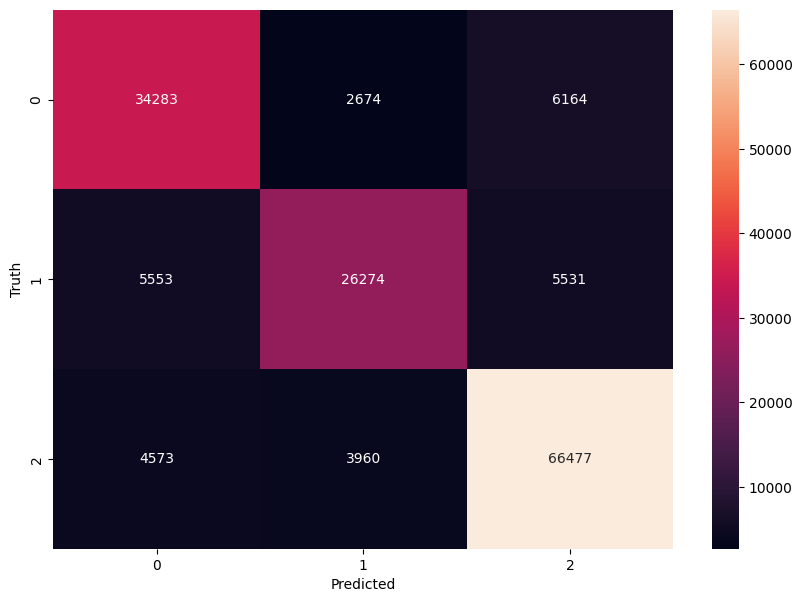

In [39]:
# Matrice de confusion
cm_types = tf.math.confusion_matrix(labels=y_test_types_2, predictions=y_predicted_labels_types)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_types, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Maj (NN)
---

Modèle ...

In [40]:
model_get_maj = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dropout(0.5), # dropout : 0.5 pour éviter l'overfitting (sur-apprentissage)
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_maj.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [41]:
model_get_maj.fit(
    X_train_Maj, 
    y_train_Maj_2, 
    epochs=10, 
    batch_size=32, 
    validation_data=(
        X_validation_Maj, 
        y_validation_Maj_2
    ),
    verbose=1
)
# accuracy : 0.9506
# loss : 0.1719
# Temps : 4m 2.7s

Epoch 1/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.8106 - loss: 0.6989
Epoch 2/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9173 - loss: 0.2998
Epoch 3/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9295 - loss: 0.2527
Epoch 4/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9353 - loss: 0.2303
Epoch 5/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9389 - loss: 0.2131
Epoch 6/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9417 - loss: 0.2001
Epoch 7/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9450 - loss: 0.1948
Epoch 8/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9465 - loss: 0.1868
Epoch 9/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9503 - loss: 0.1717
Epoch 10/10
4699/4699 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9506 - loss: 0.1719


In [ ]:
test_loss_maj, test_acc_maj = model_get_maj.evaluate(X_test_Maj, y_test_Maj_2)
print(f"Test accuracy : {test_acc_maj}") # Test accuracy : 
print(f"Test loss : {test_loss_maj}") # Test loss : 
# Temps : 

In [42]:
# Sauvegarder le modèle
model_get_maj.save("../models/Get_Maj.keras")  # Format HDF5 (.h5)

In [43]:
y_predicted_Maj = model_get_maj.predict(X_test_Maj)
y_predicted_Maj[1]
# Temps 1.8s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([7.6653678e-06, 8.1950868e-04, 2.4872288e-11, 2.1957176e-05,
       1.6301229e-07, 7.5653603e-04, 7.2221155e-04, 4.1640198e-04,
       4.8323109e-05, 4.6709978e-05, 2.0198415e-04, 6.8944707e-03,
       7.9348123e-05, 4.4218441e-03, 2.7856623e-13, 7.5334677e-04,
       1.8632639e-15, 1.3265259e-09, 5.9204374e-04, 4.1178381e-01,
       1.3050163e-02, 9.7222239e-01, 9.0721514e-08, 9.9674737e-01,
       1.0000000e+00, 2.7380546e-12], dtype=float32)

In [44]:
np.argmax(y_predicted_Maj[1])

24

In [45]:
# y_predicted_labels_Maj = [correspondance_Maj[np.argmax(i)] for i in y_predicted_Maj]
y_predicted_labels_Maj = [np.argmax(i) for i in y_predicted_Maj]
y_predicted_labels_Maj[:5]

[8, 24, 1, 19, 20]

Text(95.72222222222221, 0.5, 'Truth')

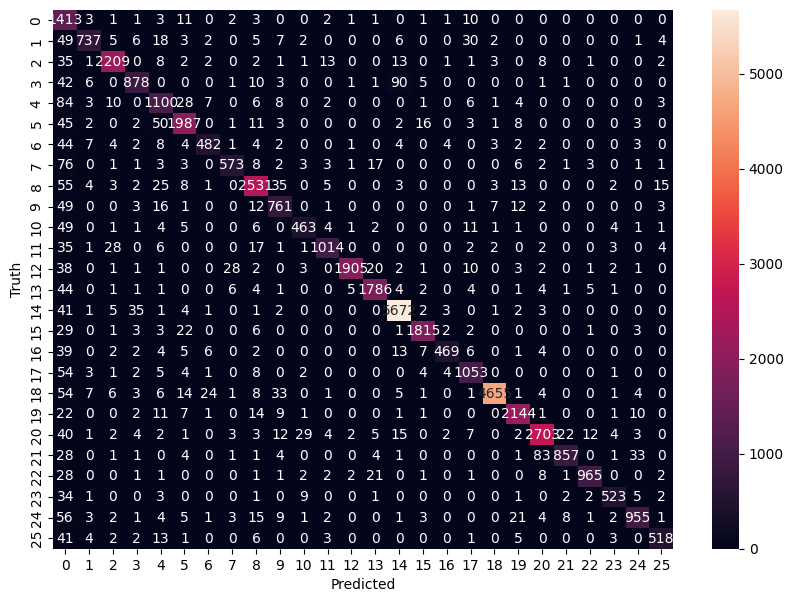

In [46]:
# Matrice de confusion
cm_Maj = tf.math.confusion_matrix(labels=y_test_Maj_2, predictions=y_predicted_labels_Maj)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Maj, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Min (NN)
---

Modèle ...

In [47]:
model_get_min = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dropout(0.5), # dropout : 0.5 pour éviter l'overfitting (sur-apprentissage)
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_min.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [48]:
model_get_min.fit(
    X_train_Min, 
    y_train_Min_2, 
    epochs=10, 
    batch_size=32, 
    validation_data=(
        X_validation_Min, 
        y_validation_Min_2
    ),
    verbose=1
)
# accuracy : 0.9276
# loss : 0.2222
# Temps : 2m 45.3s

Epoch 1/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.7782 - loss: 0.8087
Epoch 2/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.8855 - loss: 0.3841
Epoch 3/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9002 - loss: 0.3296
Epoch 4/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9065 - loss: 0.3053
Epoch 5/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9134 - loss: 0.2759
Epoch 6/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9181 - loss: 0.2599
Epoch 7/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9213 - loss: 0.2480
Epoch 8/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9249 - loss: 0.2360
Epoch 9/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9271 - loss: 0.2305
Epoch 10/10
3492/3492 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9276 - loss: 0.2222


In [ ]:
test_loss_min, test_acc_min = model_get_min.evaluate(X_test_Min, y_test_Min_2)
print(f"Test accuracy : {test_acc_min}") # Test accuracy : 
print(f"Test loss : {test_loss_min}") # Test loss : 
# Temps : 

In [49]:
# Sauvegarder le modèle
model_get_min.save("../models/Get_Min.keras")  # Format keras (.keras)

In [50]:
y_predicted_Min = model_get_min.predict(X_test_Min)
y_predicted_Min[1]

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step


array([5.9772796e-05, 7.2387469e-01, 3.6721583e-04, 6.8616682e-06,
       9.7494113e-01, 1.9543942e-03, 3.8342534e-03, 7.3375348e-03,
       8.0742911e-03, 3.3488695e-03, 3.2576269e-01, 1.7258851e-01,
       8.0805256e-18, 1.1596943e-05, 2.4125614e-20, 2.3796012e-13,
       6.6982694e-02, 2.1890946e-01, 3.9881041e-08, 9.9999982e-01,
       1.7495331e-06, 1.3000210e-02, 1.8403134e-07, 3.2485554e-05,
       5.0774548e-02, 4.4317822e-08], dtype=float32)

In [51]:
# y_predicted_labels_Min = [correspondance_Min[np.argmax(i)] for i in y_predicted_Min]
y_predicted_labels_Min = [np.argmax(i) for i in y_predicted_Min]
y_predicted_labels_Min[:5]

[4, 19, 25, 3, 4]

Text(95.72222222222221, 0.5, 'Truth')

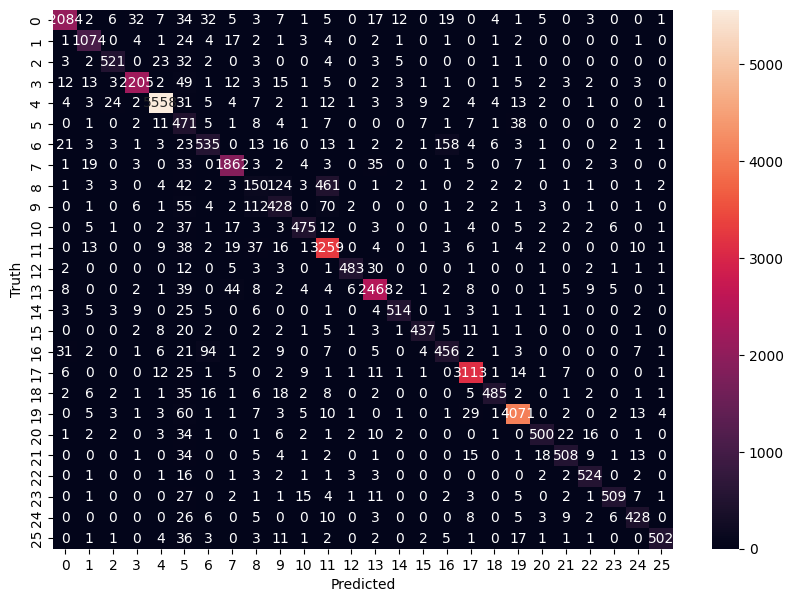

In [52]:
# Matrice de confusion
cm_Min = tf.math.confusion_matrix(labels=y_test_Min_2, predictions=y_predicted_labels_Min)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Min, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Nbr (NN)
---

Modèle ...

In [53]:
model_get_nbr = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(625, activation='relu'),
    keras.layers.Dropout(0.5), # dropout : 0.5 pour éviter l'overfitting (sur-apprentissage)
    keras.layers.Dense(156, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_nbr.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
model_get_nbr.fit(
    X_train_Nbr, 
    y_train_Nbr_2, 
    epochs=10, 
    batch_size=32,
    validation_data=(
        X_validation_Nbr, 
        y_validation_Nbr_2
    ),
    verbose=1
)
# accuracy : 0.9330
# loss : 0.1897
# Temps : 6m 16.0s

Epoch 1/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.8770 - loss: 0.4038
Epoch 2/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9224 - loss: 0.2328
Epoch 3/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9254 - loss: 0.2179
Epoch 4/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9278 - loss: 0.2082
Epoch 5/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9290 - loss: 0.2041
Epoch 6/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9297 - loss: 0.2005
Epoch 7/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9300 - loss: 0.1991
Epoch 8/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9312 - loss: 0.1957
Epoch 9/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.9304 - loss: 0.1957
Epoch 10/10
7037/7037 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9330 - loss: 0.1897


In [ ]:
test_loss_nbr, test_acc_nbr = model_get_nbr.evaluate(X_test_Nbr, y_test_Nbr_2)
print(f"Test accuracy : {test_acc_nbr}") # Test accuracy : 
print(f"Test loss : {test_loss_nbr}") # Test loss : 
# Temps : 

In [55]:
# Sauvegarder le modèle
model_get_nbr.save("../models/Get_Nbr.keras")  # Format keras (.keras)

In [56]:
y_predicted_Nbr = model_get_nbr.predict(X_test_Nbr)
y_predicted_Nbr[1]
# Temps : 3.4s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


array([3.6999252e-02, 2.0050801e-02, 9.9971640e-01, 1.0000000e+00,
       2.2368295e-07, 9.9969828e-01, 2.3797769e-03, 1.2830599e-01,
       9.9982297e-01, 9.9779505e-01, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [57]:
# y_predicted_labels_Nbr = [correspondance_Nbr[np.argmax(i)] for i in y_predicted_Nbr]
y_predicted_labels_Nbr = [np.argmax(i) for i in y_predicted_Nbr]
y_predicted_labels_Nbr[:5]

[4, 3, 9, 7, 1]

Text(95.72222222222221, 0.5, 'Truth')

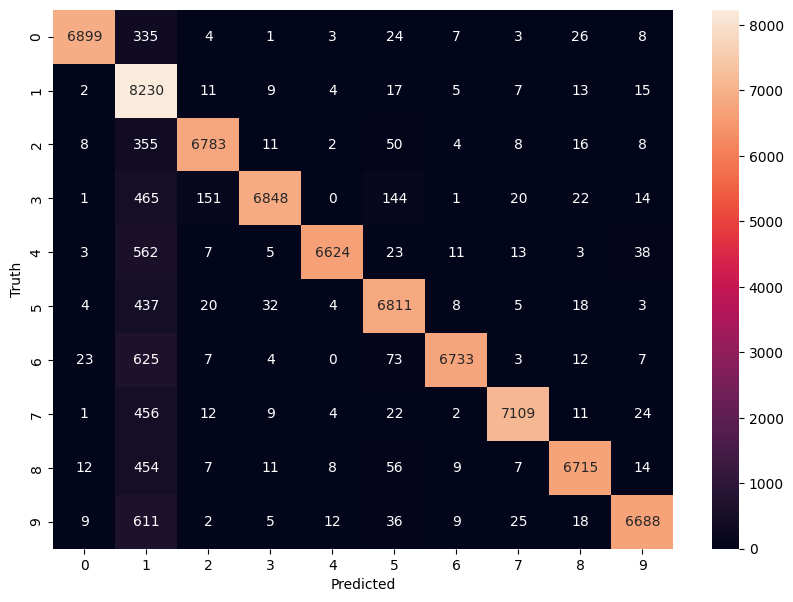

In [58]:
# Matrice de confusion
cm_Nbr = tf.math.confusion_matrix(labels=y_test_Nbr_2, predictions=y_predicted_labels_Nbr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Nbr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')